In [42]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/air-france-reviews-dataset/airfrance_tripadvisor_reviews.csv


In [43]:
import pandas as pd

df = pd.read_csv('/kaggle/input/air-france-reviews-dataset/airfrance_tripadvisor_reviews.csv')

# İlk satırlara bakalım
df.head()

,rating,title,text,publishedDate
0,1,WORST AIRLINE,I travel a lot - and I travel often. Last week...,2024-11-13
1,1,Terrible experience with Airfrance,"This review is regarding flight AF185, we book...",2024-11-13
2,1,Extremely Disappointing Experience with Air Fr...,I recently flew with Air France on flight #185...,2024-11-12
3,1,Horrible,Wow!!! What a horrible experience!! I've alway...,2024-11-11
4,1,The Worst Flight Experience I’ve Ever Had,I spent a fantastic 10-day vacation in Hong Ko...,2024-11-11


In [44]:
print(df.columns)

# Boş değerleri kontrol et
print(df.isnull().sum())

# Yorum metni, başlık, duygu ve tarih sütunlarını kontrol edelim
df = df[['title', 'text', 'rating', 'publishedDate']].dropna()

# Yorum metni oluştur (başlık + içerik)
df['full_text'] = df['title'] + ' ' + df['text']

Index(['rating', 'title', 'text', 'publishedDate'], dtype='object')
rating           0
title            0
text             0
publishedDate    0
dtype: int64


In [45]:
def rating_to_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    else:
        return 'negative'

df['sentiment'] = df['rating'].apply(rating_to_sentiment)

In [46]:
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

stop_words = ENGLISH_STOP_WORDS

def preprocess_text(text):
    # Küçük harfe çevirme
    text = text.lower()
    # Noktalama kaldırma
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Kelimelere ayırma ve stop word temizliği
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['clean_text'] = df['full_text'].apply(preprocess_text)


In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF vektörleştirme (ilk 5000 en anlamlı kelime ile sınırlayabiliriz)
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['clean_text'])

# Hedef değişken (sentiment)
y = df['sentiment']


In [48]:
from sklearn.model_selection import train_test_split

# %80 eğitim, %20 test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_preds = nb_model.predict(X_test)

print("Naive Bayes:\n", classification_report(y_test, nb_preds, zero_division=0))

Naive Bayes:
               precision    recall  f1-score   support

    negative       0.82      0.80      0.81       181
     neutral       0.00      0.00      0.00        79
    positive       0.71      0.94      0.81       252

    accuracy                           0.75       512
   macro avg       0.51      0.58      0.54       512
weighted avg       0.64      0.75      0.69       512



In [50]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=200)
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

print("Logistic Regression:\n", classification_report(y_test, lr_preds, zero_division=0))

Logistic Regression:
               precision    recall  f1-score   support

    negative       0.79      0.89      0.84       181
     neutral       0.43      0.08      0.13        79
    positive       0.79      0.92      0.85       252

    accuracy                           0.78       512
   macro avg       0.67      0.63      0.61       512
weighted avg       0.74      0.78      0.74       512



In [51]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

print("Random Forest:\n", classification_report(y_test, rf_preds, zero_division=0))

Random Forest:
               precision    recall  f1-score   support

    negative       0.77      0.88      0.82       181
     neutral       0.00      0.00      0.00        79
    positive       0.75      0.91      0.82       252

    accuracy                           0.76       512
   macro avg       0.51      0.60      0.55       512
weighted avg       0.64      0.76      0.70       512



In [52]:
tfidf_words = vectorizer.get_feature_names_out()
idf_values = vectorizer.idf_

# Kelimeleri ve IDF değerlerini eşleştir
idf_df = pd.DataFrame({'word': tfidf_words, 'idf': idf_values})

# En yüksek IDF değerine sahip 10 kelime (en nadir ve özel kelimeler)
top_idf_words = idf_df.sort_values(by='idf', ascending=False).head(10)

print("🔍 En Değerli (Yüksek IDF) 10 Kelime:")
print(top_idf_words)

🔍 En Değerli (Yüksek IDF) 10 Kelime:
                 word       idf
0                 000  8.155006
2941             milk  8.155006
2790              lux  8.155006
2783           luggae  8.155006
816           camille  8.155006
2777           luagge  8.155006
2762            louis  8.155006
186           8533120  8.155006
3933          scooter  8.155006
2224  hospitalization  8.155006


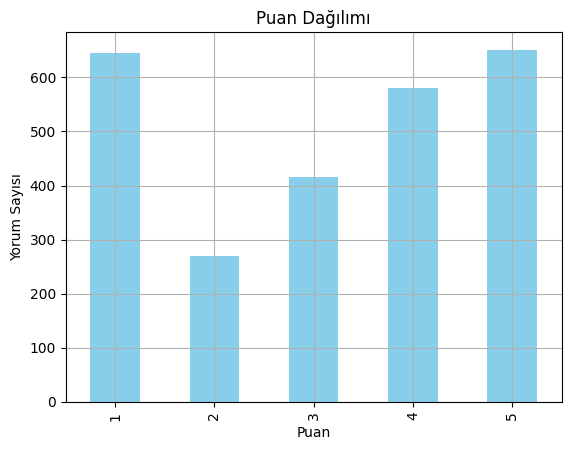

In [53]:
import matplotlib.pyplot as plt

# 'rating' sütunu üzerinden analiz yapılmalı
df['rating'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title("Puan Dağılımı")
plt.xlabel("Puan")
plt.ylabel("Yorum Sayısı")
plt.grid(True)
plt.show()

Ortalama Yorum Uzunluğu: 650.135546875


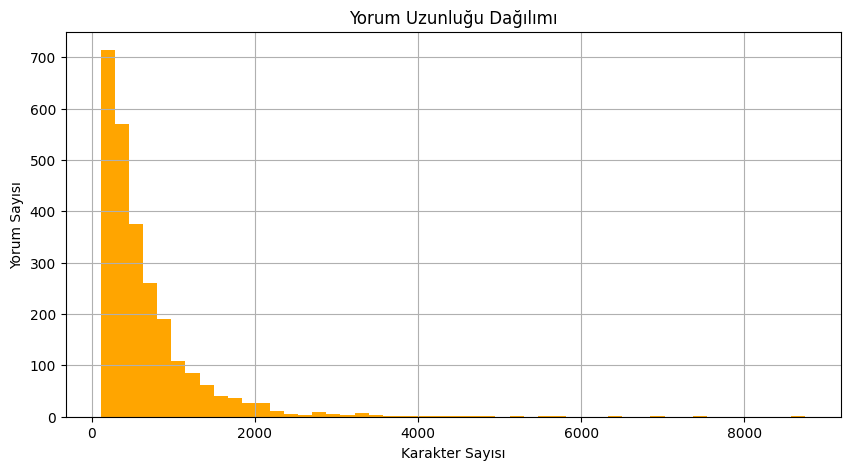

In [54]:
# 'full_text' sütununu kullanıyoruz çünkü title + text birleşimi
df['review_length'] = df['full_text'].apply(lambda x: len(str(x)))

# Ortalama uzunluk
print("Ortalama Yorum Uzunluğu:", df['review_length'].mean())

# Uzunluk dağılımı
df['review_length'].hist(bins=50, figsize=(10,5), color='orange')
plt.title("Yorum Uzunluğu Dağılımı")
plt.xlabel("Karakter Sayısı")
plt.ylabel("Yorum Sayısı")
plt.show()

In [55]:
print("🟢 En Uzun Yorum:\n")
print(df.loc[df['review_length'].idxmax(), 'full_text'])

print("\n🔴 En Kısa Yorum:\n")
print(df.loc[df['review_length'].idxmin(), 'full_text'])

🟢 En Uzun Yorum:

Delays & lost baggage I received an email from Tripadvisor asking me to review a recent flight. Apologies as it is not a short story. Before my most recent flight I want to take you back to July 2017 when I flew with Air France from Birmingham via Paris to Johannesburg. I should point out that my final destination was Durban, but Air France could not take a flight booking on line for Durban. My wife and I have flown several times on this route and we even joined the Flying Blue scheme to gain air miles with Air France. My wife though decided a couple of years she would use a different airline, and this so far has been a good choice.
I arrived early at Birmingham International and the check in desk was still open for an earlier flight to Paris. Bonus as this meant not having to sit with my bag for two hours without being able to get through passport control. As soon as I got through security I read that my flight had been delayed. After an hour I tracked down a lady to

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF vektörleştirme (maksimum 1000 kelime ile sınırlı)
vectorizer = TfidfVectorizer(max_features=1000)

# Temizlenmiş metin verisini sayısal vektöre dönüştür
X = vectorizer.fit_transform(df['clean_text'])

# Özellik matrisinin boyutu
print("Özellik matrisinin boyutu:", X.shape)

Özellik matrisinin boyutu: (2560, 1000)


In [57]:
# TF-IDF nesnesinden kelime isimlerini ve IDF değerlerini al
tfidf_words = vectorizer.get_feature_names_out()
idf_values = vectorizer.idf_

# İlk 10 kelime ve IDF değerlerini yazdır
print("\nİlk 10 kelime ve IDF değerleri:")
for word, idf in zip(tfidf_words[:10], idf_values[:10]):
    print(f"{word}: IDF={idf:.2f}")


İlk 10 kelime ve IDF değerleri:
10: IDF=4.09
100: IDF=5.21
11: IDF=5.26
12: IDF=4.53
13: IDF=5.63
14: IDF=5.52
15: IDF=4.57
1st: IDF=5.59
20: IDF=4.54
24: IDF=5.38


In [58]:
# TF-IDF vektörleştirici nesnesinden kelime isimlerini ve IDF değerlerini al
tfidf_words = vectorizer.get_feature_names_out()
idf_values = vectorizer.idf_

# Kelime ve IDF değerlerini DataFrame içinde eşleştir
idf_df = pd.DataFrame({'word': tfidf_words, 'idf': idf_values})

# IDF değerine göre azalan şekilde sırala, en nadir 10 kelimeyi al
top_idf_words = idf_df.sort_values(by='idf', ascending=False).head(10)

# Yazdır
print("🔍 En Değerli (Yüksek IDF) 10 Kelime:")
print(top_idf_words)

🔍 En Değerli (Yüksek IDF) 10 Kelime:
              word       idf
848       stroller  6.545568
283            dog  6.363246
669       premiere  6.363246
414         havana  6.209096
709       receipts  6.140103
724  reimbursement  6.075564
532         madrid  6.075564
482           kong  6.075564
429           hong  6.075564
315             eu  6.014940


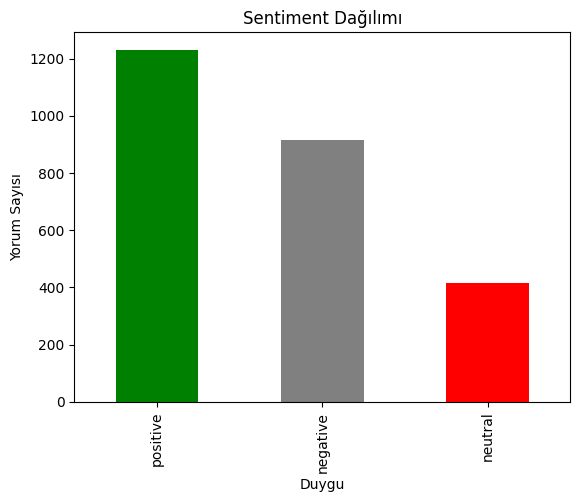

In [59]:
import matplotlib.pyplot as plt

df['sentiment'].value_counts().plot(kind='bar', color=['green', 'gray', 'red'])
plt.title("Sentiment Dağılımı")
plt.xlabel("Duygu")
plt.ylabel("Yorum Sayısı")
plt.show()

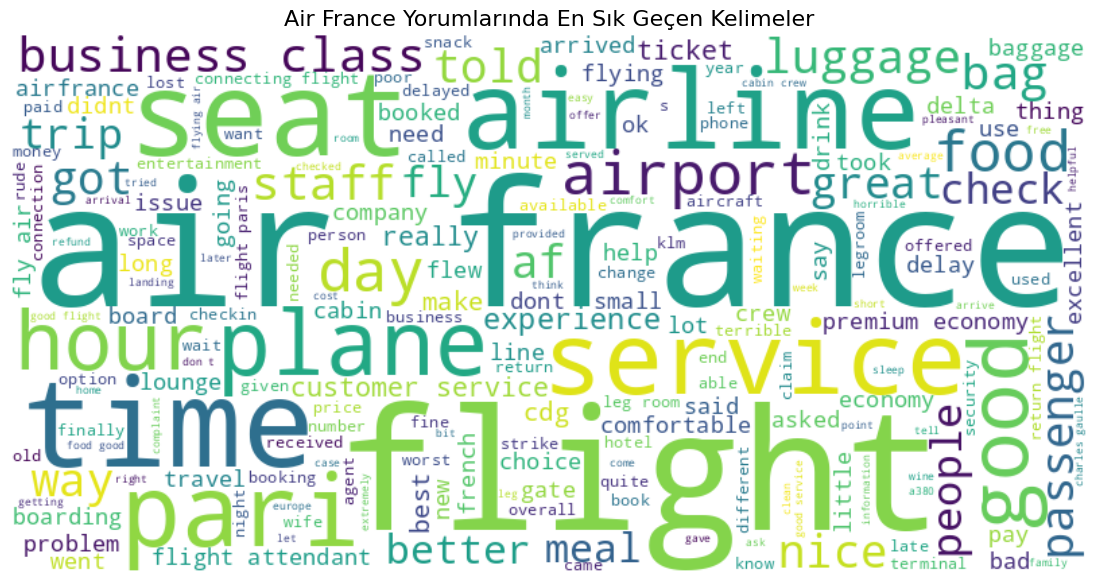

In [60]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Kelime bulutu oluşturma
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['clean_text']))

# Görselleştirme
plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Air France Yorumlarında En Sık Geçen Kelimeler", fontsize=16)
plt.show()

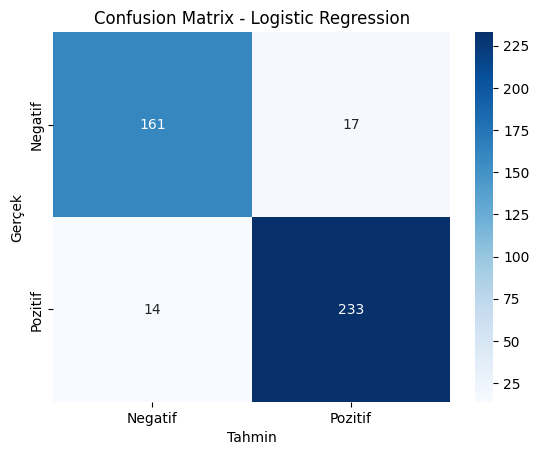

In [61]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Model tahmini (örneğin Logistic Regression)
y_pred = lr_model.predict(X_test)

# Confusion Matrix oluştur
cm = confusion_matrix(y_test, y_pred, labels=['negative', 'positive'])

# Görselleştirme
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negatif', 'Pozitif'],
            yticklabels=['Negatif', 'Pozitif'])

plt.xlabel('Tahmin')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()